# Lab 08 assignment (20 pts)

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Introduction

### Objectives
* Explore spatial and temporal relationships of time series data
* Work with Pandas Timestamp and Python DateTime objects
* Handle data gaps effectively
* Determine correlation of time-series records
* Investigate and interpret spatial and temporal autocorrelation
* Try out some interpolation routines to create continuous gridded values from sparse points
* Visualize recent snow accumulation in your region
* Learn about the SNOTEL network and explore some fundamental concepts and metrics for snow science

### Instructions  
- For each question or task below, write some code in the empty cell and execute to preserve your output 
- If you are in the graduate section of the class, please complete the challenge questions
- Work together, consult resources we've discussed, post on slack!

## Part 0: Imports and filenames
### First, let's import the libraries we'll need. Make sure to shut down any other kernels you have running!

In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import contextily as ctx
import scipy.stats
import scipy.interpolate
import tqdm
from pathlib import Path
import xarray as xr
import skgstat as skg
import seaborn as sns
import pysal
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib_scalebar.scalebar import ScaleBar

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
snotel_data_dir = f'{Path.home()}/gda_demo_data/snotel_data'

In [3]:
!ls -lh {snotel_data_dir}

total 1.1G
-rw-r--r-- 1 eric eric 1.1G Feb 27 19:10 snotel_data.nc
-rw-r--r-- 1 eric eric 456K Feb 27 19:09 snotel_stations.geojson


## Part 1: Explore the SNOTEL sites (4 pts)

### Load SNOTEL sites geojson

In [4]:
all_stations_gdf = gpd.read_file(f'{snotel_data_dir}/snotel_stations.geojson').set_index('code')
all_stations_gdf

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
code,,,,,,,,,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,41.235828,-120.791924,California,180200021403,10TFL,Great Basin Ranges,1983-10-01,2025-02-27,True,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,37.522171,-112.271179,Utah,160300020301,12SUG,Colorado Plateau,1994-10-01,2025-02-27,True,POINT (-112.27118 37.52217)
916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,45.597229,-111.959023,Montana,100200050701,12TVR,Central Montana Rocky Mountains,1996-09-01,2025-02-27,True,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,61.749668,-150.889664,Alaska,190205051106,05VPJ,None,2014-08-28,2025-02-27,True,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,47.779572,-121.698471,Washington,171100100501,10TET,Cascade Range,1994-09-01,2025-02-27,True,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLT,Slate Creek,CCSS,1737.360000,41.043980,-122.480103,California,180200050304,10TEL,Klamath Mountains,2004-10-01,2025-02-27,True,POINT (-122.4801 41.04398)
SLI,Slide Canyon,CCSS,2804.160000,38.091234,-119.431881,California,180400090501,11SKC,Sierra Nevada,2005-10-01,2025-02-27,True,POINT (-119.43188 38.09123)
SLK,South Lake,CCSS,2926.080000,37.175903,-118.562660,California,180901020601,11SLB,Sierra Nevada,2004-10-01,2025-02-27,True,POINT (-118.56266 37.1759)


### Let's quickly visualize with `.explore()`
* *When you're done, comment the following cell out, and rerun the cell to clear the plot, then save the notebook*

In [5]:
#all_stations_gdf.drop(columns=['beginDate','endDate']).explore(column='elevation_m', cmap='inferno')

#### *Written response: Where are station locations the most dense? Are there any areas you think are undersampled?*

**STUDENT WRITTEN RESPONSE HERE**

### Load in state data, filter out Alaska stations, and reproject
* Can use the same Albers Equal Area projection from previous labs, or recompute based on bounds and center of SNOTEL sites

In [6]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

#### *Remove stations in Alaska from the `all_stations_gdf`*
- You could use the `.clip()` function, or maybe even easier you can use the `all_stations_gdf` `name` column

In [7]:
# STUDENT CODE HERE

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
code,,,,,,,,,,,,,
755_NM_SNTL,Signal Peak,SNOTEL,2548.127930,32.924011,-108.145378,New Mexico,150400010803,12SYB,Southwest Basins and Ranges,1978-10-01,2025-02-27,True,POINT (-108.14538 32.92401)
1048_NM_SNTL,Mcknight Cabin,SNOTEL,2816.352051,33.008121,-107.869751,New Mexico,130302020103,13SBS,Southwest Basins and Ranges,2003-09-25,2025-02-27,True,POINT (-107.86975 33.00812)
595_NM_SNTL,Lookout Mountain,SNOTEL,2590.800049,33.360271,-107.831223,New Mexico,150400010402,13SBS,Southwest Basins and Ranges,1978-10-01,2025-02-27,True,POINT (-107.83122 33.36027)
757_NM_SNTL,Silver Creek Divide,SNOTEL,2743.199951,33.371059,-108.706177,New Mexico,150400040605,12SYB,Southwest Basins and Ranges,1978-10-01,2025-02-27,True,POINT (-108.70618 33.37106)
486_NM_SNTL,Frisco Divide,SNOTEL,2438.399902,33.736462,-108.945023,New Mexico,150400040303,12SXC,Colorado Plateau,1971-10-01,2025-02-27,True,POINT (-108.94502 33.73646)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159_WA_SNTL,Gold Axe Camp,SNOTEL,1633.728027,48.951599,-118.986397,Washington,170200021204,11ULQ,Columbia Mountains,2010-10-01,2025-02-27,True,POINT (-118.9864 48.9516)
1107_WA_SNTL,Buckinghorse,SNOTEL,1484.375977,47.708599,-123.457474,Washington,171100200501,10TDT,Olympic Mountains,2008-06-19,2025-02-27,True,POINT (-123.45747 47.7086)
648_WA_SNTL,Mount Crag,SNOTEL,1207.008057,47.763699,-123.026001,Washington,171100180601,10TDT,Olympic Mountains,1989-10-01,2025-02-27,True,POINT (-123.026 47.7637)


#### *Calculate the convex hull of the remaining stations. Create an Albers Equal Area projection string, using the center of the convex hull as the center lat and lon, and the min and max latitude bound of the convex hull as the standard parallels.*
- Hint: We did something similar in lab 03!

In [8]:
# STUDENT CODE HERE

In [9]:
# STUDENT CODE HERE

'+proj=aea +lat_1=32.92 +lat_2=48.98 +lat_0=41.66 +lon_0=-113.61'

#### *Reproject our stations and states geodataframes to this new projection, and then create a plot of SNOTEL station locations and elevations overlaid on the states geometries and a basemap.*

In [10]:
all_stations_gdf = all_stations_gdf.to_crs(proj_str_aea)
states_gdf = states_gdf.to_crs(proj_str_aea)

In [11]:
# STUDENT CODE HERE

<img src='imgs/snotel_stations.png' width="800" />

#### *Print the station name, code, latitude, longitude, state, and elevation of the highest and lowest stations* 

In [12]:
# STUDENT CODE HERE

#### *Create `wa_stations_gdf`, a geodataframe of just the stations in Washington. Create a figure with three plots: a map of all of the stations (still excluding Alaska), a map of the Washington stations, and then one plot with their respective elevation histograms.*
- To get the layout similar to the example output, maybe give [subplot_mosaic](https://matplotlib.org/stable/users/explain/axes/mosaic.html) a try!

In [13]:
wa_stations_gdf = all_stations_gdf[all_stations_gdf['state']=='Washington']
wa_stations_gdf

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
code,,,,,,,,,,,,,
1231_WA_SNTL,Satus Pass,SNOTEL,1207.008057,45.987968,-120.677338,Washington,170701060301,10TFR,Columbia Plateau,2012-08-23 00:00:00,2025-02-27,True,POINT (-543481.686 506823.621)
1129_WA_SNTL,Indian Rock,SNOTEL,1633.728027,45.990768,-120.807671,Washington,170701060301,10TFR,Columbia Plateau,2008-10-01 00:00:00,2025-02-27,True,POINT (-553456.824 507945.588)
804_WA_SNTL,Surprise Lakes,SNOTEL,1307.592041,46.094971,-121.763451,Washington,170800020107,10TES,Cascade Range,1978-10-01 00:00:00,2025-02-27,True,POINT (-625678.614 525941.149)
1109_WA_SNTL,Calamity,SNOTEL,762.000000,45.903622,-122.216331,Washington,170800020603,10TER,Cascade Range,2008-08-21 13:00:00,2025-02-27,True,POINT (-662408.042 507935.784)
1104_WA_SNTL,Pepper Creek,SNOTEL,652.271973,46.102421,-121.955551,Washington,170800020111,10TES,Cascade Range,2007-08-15 00:00:00,2025-02-27,True,POINT (-640297.907 528148.262)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159_WA_SNTL,Gold Axe Camp,SNOTEL,1633.728027,48.951599,-118.986397,Washington,170200021204,11ULQ,Columbia Mountains,2010-10-01 00:00:00,2025-02-27,True,POINT (-393507.081 827717.25)
1107_WA_SNTL,Buckinghorse,SNOTEL,1484.375977,47.708599,-123.457474,Washington,171100200501,10TDT,Olympic Mountains,2008-06-19 00:00:00,2025-02-27,True,POINT (-735115.743 718322.713)
648_WA_SNTL,Mount Crag,SNOTEL,1207.008057,47.763699,-123.026001,Washington,171100180601,10TDT,Olympic Mountains,1989-10-01 00:00:00,2025-02-27,True,POINT (-702377.025 720918.663)


In [14]:
# STUDENT CODE HERE

<img src='imgs/snotel_stations_all_wa_comparison.png' width="800" />

#### *Written response: Imagine using traditional statistical tests to answer each of the following questions. For each, comment on whether you think spatial autocorrelation is a concern and why. For traditional statistics, what assumptions are violated due to spatial autocorrelation?*
- *Based on the SNOTEL station data, is the average elevation in Washington different from the rest of the Contiguous US?*
- *Are Washington's SNOTEL station elevations representative of the broader SNOTEL network?*

**STUDENT WRITTEN RESPONSE HERE**

## Part 2: Single site time series analysis and temporal autocorrelation (5 pts)

#### *Index into `snotel_ds` to load data from [Paradise site (ID 679) on Mt. Rainer](https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=679) as `paradise_snotel_ds`*

In [15]:
snotel_ds = xr.open_dataset(f'{snotel_data_dir}/snotel_data.nc').load()
snotel_ds

<xarray.Dataset> Size: 1GB
Dimensions:        (station: 969, time: 24173)
Coordinates: (12/16)
  * time           (time) datetime64[ns] 193kB 1909-04-13 ... 2025-02-27
  * station        (station) <U12 47kB '1135_UT_SNTL' ... '915_ID_SNTL'
    name           (station) <U24 93kB 'Burts Miller Ranch' ... 'Schwartz Lake'
    network        (station) <U6 23kB 'SNOTEL' 'SNOTEL' ... 'SNOTEL' 'SNOTEL'
    elevation_m    (station) float64 8kB 2.438e+03 2.377e+03 ... 2.63e+03
    latitude       (station) float64 8kB 40.98 44.79 37.16 ... 40.28 42.3 44.85
    ...             ...
    mountainRange  (station) <U32 124kB '' ... 'Idaho-Bitterroot Rocky Mounta...
    beginDate      (station) datetime64[ns] 8kB 2009-10-01 ... 1995-09-26
    endDate        (station) datetime64[ns] 8kB 2025-02-27 ... 2025-02-27
    csvData        (station) bool 969B True True True True ... True True True
    WY             (time) int64 193kB 1909 1955 1955 1955 ... 2025 2025 2025
    DOWY           (time) int64 193kB 195 62 63 64 65 66 ... 146 147 148 149 150
Data variables:
    TAVG           (station, time) float64 187MB nan nan nan ... -4.6 -2.7 nan
    TMIN           (station, time) float64 187MB nan nan nan ... -6.8 -7.0 nan
    TMAX           (station, time) float64 187MB nan nan nan ... -0.1 4.0 nan
    SNWD           (station, time) float64 187MB nan nan nan ... 0.9398 0.9398
    WTEQ           (station, time) float64 187MB nan nan nan ... 0.2286 0.2286
    PRCPSA         (station, time) float64 187MB nan nan nan nan ... 0.0 nan nan

In [16]:
station_id = '679_WA_SNTL'

In [17]:
# STUDENT CODE HERE

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 24173)
Coordinates: (12/16)
  * time           (time) datetime64[ns] 193kB 1909-04-13 ... 2025-02-27
    station        <U12 48B '679_WA_SNTL'
    name           <U24 96B 'Paradise'
    network        <U6 24B 'SNOTEL'
    elevation_m    float64 8B 1.564e+03
    latitude       float64 8B 46.78
    ...             ...
    mountainRange  <U32 128B 'Cascade Range'
    beginDate      datetime64[ns] 8B 1979-10-01
    endDate        datetime64[ns] 8B 2025-02-27
    csvData        bool 1B True
    WY             (time) int64 193kB 1909 1955 1955 1955 ... 2025 2025 2025
    DOWY           (time) int64 193kB 195 62 63 64 65 66 ... 146 147 148 149 150
Data variables:
    TAVG           (time) float64 193kB nan nan nan nan ... 1.3 -1.3 -2.5 nan
    TMIN           (time) float64 193kB nan nan nan nan ... -1.7 -3.7 -4.9 nan
    TMAX           (time) float64 193kB nan nan nan nan nan ... 3.2 3.0 -1.6 nan
    SNWD           (time) float64 193kB nan nan nan nan ... 2.972 nan 3.378
    WTEQ           (time) float64 193kB nan nan nan nan ... 1.331 1.374 1.372
    PRCPSA         (time) float64 193kB nan nan nan nan ... 0.0432 0.0025 nan

### Here we'll use the `.to_pandas()` function to turn our xarray dataset into a pandas dataframe

In [18]:
paradise_snotel_df = paradise_snotel_ds.to_pandas()[['SNWD', 'TAVG','PRCPSA','WY','DOWY']]
paradise_snotel_df

,SNWD,TAVG,PRCPSA,WY,DOWY
time,,,,,
1909-04-13,NaN,NaN,NaN,1909,195
1954-12-01,NaN,NaN,NaN,1955,62
1954-12-02,NaN,NaN,NaN,1955,63
1954-12-03,NaN,NaN,NaN,1955,64
1954-12-04,NaN,NaN,NaN,1955,65
...,...,...,...,...,...
2025-02-23,3.2512,1.8,0.0432,2025,146
2025-02-24,3.0734,1.3,0.0178,2025,147
2025-02-25,2.9718,-1.3,0.0432,2025,148


#### *Written response: You'll notice we preserved the `WY` and `DOWY` columns. Read the [water year wikipedia page](https://en.wikipedia.org/wiki/Water_year). Why might water year and day of water year (DOWY) be useful for us when comparing snow hydrology data?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Plot snow depth vs day of water year, with colors representing average temperatures* 

In [19]:
# STUDENT CODE HERE

<img src='imgs/paradise_snotel_snwd_vs_dowy_and_temp.png' width="800" />

#### *Written response: Answer the following by inspecting the graph above. What is the approximate average maximum snow depth, and around what day does this occur? Around what average temperatures does it seem that snow depth decreases the fastest, and around what day does this usually occur? Around what day does snow usually disappear? Approximately what day did the snow disappear earliest? Latest? Please report the dates as both DOWY and calendar dates.*

**STUDENT WRITTEN RESPONSE HERE**

#### *Compute statistics for each day of water year, using values from all years*
* Seems like a Pandas groupby/agg might work here
* Include min, max, mean, and median

In [20]:
stat_list = ['count','min','max','mean','std','median']

In [21]:
# STUDENT CODE HERE

,count,min,max,mean,std,median
DOWY,,,,,,
1,19,0.0,0.2286,0.013368,0.052444,0.0
2,19,0.0,0.2032,0.010695,0.046617,0.0
3,19,0.0,0.2286,0.013368,0.052444,0.0
4,19,0.0,0.1270,0.012032,0.032093,0.0
5,19,0.0,0.1270,0.012032,0.033192,0.0
...,...,...,...,...,...,...
362,19,0.0,0.0254,0.001337,0.005827,0.0
363,19,0.0,0.0254,0.001337,0.005827,0.0
364,19,0.0,0.0254,0.002674,0.008009,0.0


#### *What day of water year has the highest average snow depth, and what is that snow depth? What calendar day does this correspond to?*
* Consider converting from DOWY to calendar date using `caldate = pd.to_datetime('2021-09-30')+pd.to_timedelta(DOWY, unit='D')`
* And `calmonthday = caldate.strftime('%B %d')` to convert from pandas datetime to Month / day string 

In [22]:
# STUDENT CODE HERE

The day of highest average snow depth is DOWY 197, corresponding to a calendar date of April 15, with an average snow depth of 4.00 meters.


#### *Create a plot of these aggregated dowy values, and add the current water year's daily data as a scatter plot on top*
* Your output independent variable (x-axis) should be day of water year (1-366), and dependent variable (y-axis) should be median value for that day of year, computed using aggregated values for all available years
* You can add shaded regions for standard deviation using [`ax.fill_between`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html)

In [23]:
# STUDENT CODE HERE

<img src='imgs/paradise_snotel_snwd_stats.png' width="800" />

#### *For most recent snow depth value in the record, what is the percentage of "normal"*
* This will be the snow depth from whenever you ran the download script
* Normal can be defined by long-term median for the same dowy across all years at the site

In [24]:
# STUDENT CODE HERE

Current snow depth (February 25, 2025 / DOWY 148): 2.97 meters
Long-term median on DOWY 148: 3.53 meters
Percent of normal snow depth on DOWY 148: 84.17%


### Now let's view the data as time-series plots
#### *Create a figure to plot snow depth, temperature, and precipitation for water year 2021*

In [25]:
# STUDENT CODE HERE

<img src='imgs/paradise_snotel_data_wy2021.png' width="800" />

### Now we'll calculate the temporal autocorrelation for WY 2021...

In [26]:
autocorr_snwd = []
autocorr_tavg = []
autocorr_prcp = []
autocorr_lags = np.arange(1, 365)

paradise_snotel_wy2021_df = paradise_snotel_df.loc['2020-10-01':'2021-09-30']

for i in autocorr_lags:
    autocorr_snwd.append(paradise_snotel_wy2021_df['SNWD'].autocorr(lag=i))
    autocorr_tavg.append(paradise_snotel_wy2021_df['TAVG'].autocorr(lag=i))
    autocorr_prcp.append(paradise_snotel_wy2021_df['PRCPSA'].autocorr(lag=i))

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


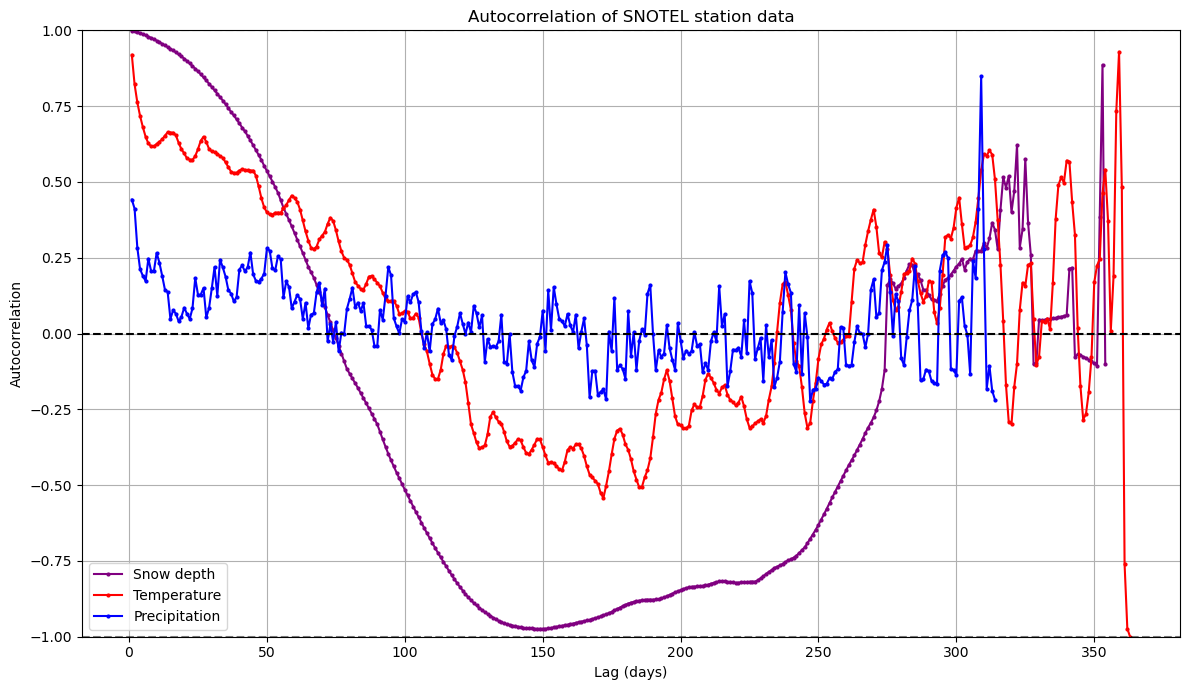

In [27]:
f,ax=plt.subplots(figsize=(12,7))
ax.plot(autocorr_lags, autocorr_snwd, marker='o', linestyle='-', color='purple', label='Snow depth',markersize=2)
ax.plot(autocorr_lags, autocorr_tavg, marker='o', linestyle='-', color='red', label='Temperature',markersize=2)
ax.plot(autocorr_lags, autocorr_prcp, marker='o', linestyle='-', color='blue', label='Precipitation',markersize=2)
ax.set_ylim([-1, 1])

ax.set_title('Autocorrelation of SNOTEL station data')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.legend()

ax.axhline(0, color='k', linestyle='--')
ax.axhline(1, color='k', linestyle='--', alpha=0.5)
ax.axhline(-1, color='k', linestyle='--', alpha=0.5)
ax.grid(True)

f.tight_layout()

#### *Written response: Compare and contrast the autocorrelation patterns among these three variables. What distinctive features do you observe in each pattern, and what physical or environmental processes might explain these differences? Also, describe the significance of the relative magnitudes of the curves, as well as the significance of the autocorrelation values at a lag distance of one day.*

**STUDENT WRITTEN RESPONSE HERE**

#### *Now plot the same variables, but this time use the full time-series*

In [28]:
# STUDENT CODE HERE

<img src='imgs/paradise_snotel_data_long.png' width="800" />

### Now we'll calculate the temporal autocorrelation for the entire time-series...

In [29]:
autocorr_snwd = []
autocorr_tavg = []
autocorr_prcp = []
autocorr_lags = np.arange(1, 365*3)

for i in autocorr_lags:
    autocorr_snwd.append(paradise_snotel_df['SNWD'].autocorr(lag=i))
    autocorr_tavg.append(paradise_snotel_df['TAVG'].autocorr(lag=i))
    autocorr_prcp.append(paradise_snotel_df['PRCPSA'].autocorr(lag=i))

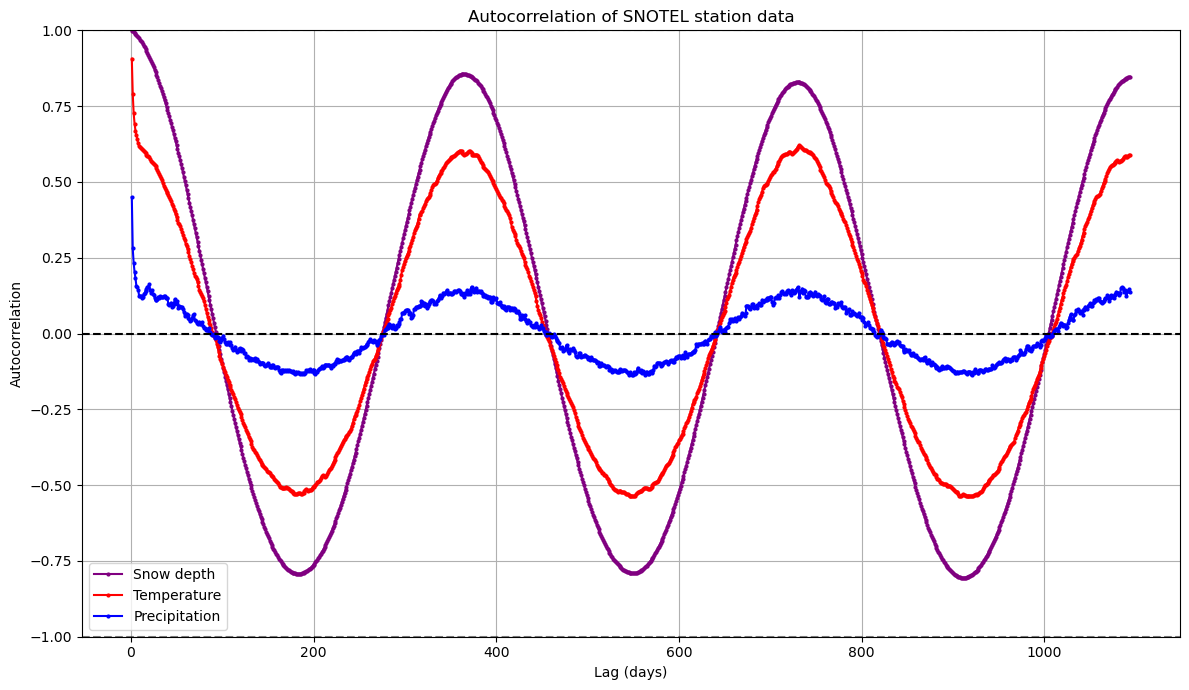

In [30]:
f,ax=plt.subplots(figsize=(12,7))
ax.plot(autocorr_lags, autocorr_snwd, marker='o', linestyle='-', color='purple', label='Snow depth', markersize=2)
ax.plot(autocorr_lags, autocorr_tavg, marker='o', linestyle='-', color='red', label='Temperature',markersize=2)
ax.plot(autocorr_lags, autocorr_prcp, marker='o', linestyle='-', color='blue', label='Precipitation',markersize=2)
ax.set_ylim([-1, 1])

ax.set_title('Autocorrelation of SNOTEL station data')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.legend()

ax.axhline(0, color='k', linestyle='--')
ax.axhline(1, color='k', linestyle='--', alpha=0.5)
ax.axhline(-1, color='k', linestyle='--', alpha=0.5)
ax.grid(True)

f.tight_layout()

#### *Written response: How might these autocorrelation patterns change at another SNOTEL site? Snow depth shows persistent positive autocorrelation over longer lags than precipitation. What implications does this have for the minimum timespan needed to characterize each process and the reliability of short-term vs. long-term forecasts?*

**STUDENT WRITTEN RESPONSE HERE**

### What would the variogram for snow depth look like here??
- Technically, we shouldn't use a variogram here because it violates an assumption of stationarity - check out a great explainer [here](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_variogram_calculation.html)
- Stationarity is violated because the mean and variance are are **not** constant across all time points, and the covariance between points does **not** only depend on distance between them
    - Think about how in the summer the mean and variability in snow depth are a lot lower than in the winter :)
- But let's plot it anyway to see what it would look like!

In [31]:
variogram_df = paradise_snotel_df["SNWD"].dropna()
delta_days = (pd.to_datetime(variogram_df.index)-pd.to_datetime(variogram_df.index.min())).days
variogram_df.index=delta_days

/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


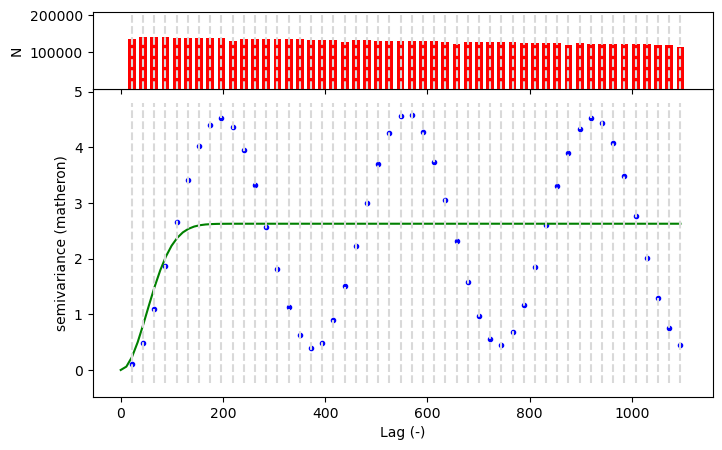

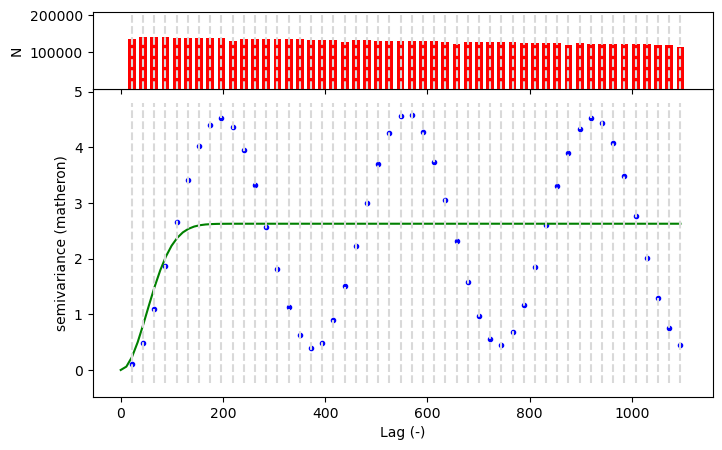

In [32]:
V = skg.Variogram(
    variogram_df.index.values,
    variogram_df.values,
    model="gaussian",
    maxlag=365*3,
    n_lags=50,
    use_nugget=True,
)
V.fit()

V.plot()

In [33]:
print("Snow depth variogram model parameters:")
print(f"Model type: {V.describe()['model']}")
print(f"Nugget: {V.describe()['nugget']:.4f}")
print(f"Sill: {V.describe()['sill']:.4f}")
print(f"Range indicates that spatial dependence extends to approximately: {V.describe()['effective_range']:.4f} days")

Snow depth variogram model parameters:
Model type: gaussian
Nugget: 0.0000
Sill: 2.6271
Range indicates that spatial dependence extends to approximately: 144.6148 days


#### *Written response: Compare the shape of the variogram plot with the autocorrelation function for snow depth. What similarities or differences do you observe, and what mathematical relationship connects these two representations of dependency? From just the variogram alone, how might you tell that the stationarity assumption has been violated?*
- Hint: Remember that the blue points show the true variances at different lag distances, and the green line is supposed to be fit to these points

**STUDENT WRITTEN RESPONSE HERE**

## Part 3: Western U.S. time-series analysis and correlation (4 pts)
Now let's take a look at the full SNOTEL time-series for the Western US 

### Inspect the SNOTEL dataset

In [34]:
snotel_ds

<xarray.Dataset> Size: 1GB
Dimensions:        (station: 969, time: 24173)
Coordinates: (12/16)
  * time           (time) datetime64[ns] 193kB 1909-04-13 ... 2025-02-27
  * station        (station) <U12 47kB '1135_UT_SNTL' ... '915_ID_SNTL'
    name           (station) <U24 93kB 'Burts Miller Ranch' ... 'Schwartz Lake'
    network        (station) <U6 23kB 'SNOTEL' 'SNOTEL' ... 'SNOTEL' 'SNOTEL'
    elevation_m    (station) float64 8kB 2.438e+03 2.377e+03 ... 2.63e+03
    latitude       (station) float64 8kB 40.98 44.79 37.16 ... 40.28 42.3 44.85
    ...             ...
    mountainRange  (station) <U32 124kB '' ... 'Idaho-Bitterroot Rocky Mounta...
    beginDate      (station) datetime64[ns] 8kB 2009-10-01 ... 1995-09-26
    endDate        (station) datetime64[ns] 8kB 2025-02-27 ... 2025-02-27
    csvData        (station) bool 969B True True True True ... True True True
    WY             (time) int64 193kB 1909 1955 1955 1955 ... 2025 2025 2025
    DOWY           (time) int64 193kB 195 62 63 64 65 66 ... 146 147 148 149 150
Data variables:
    TAVG           (station, time) float64 187MB nan nan nan ... -4.6 -2.7 nan
    TMIN           (station, time) float64 187MB nan nan nan ... -6.8 -7.0 nan
    TMAX           (station, time) float64 187MB nan nan nan ... -0.1 4.0 nan
    SNWD           (station, time) float64 187MB nan nan nan ... 0.9398 0.9398
    WTEQ           (station, time) float64 187MB nan nan nan ... 0.2286 0.2286
    PRCPSA         (station, time) float64 187MB nan nan nan nan ... 0.0 nan nan

### Create `all_stations_snwd_df`, a pandas dataframe of snow depth at all stations, with each row representing a day, and each column representing a station

In [35]:
all_stations_snwd_df = snotel_ds['SNWD'].to_pandas().T
all_stations_snwd_df

station,1135_UT_SNTL,448_MT_SNTL,TMR,872_WY_SNTL,773_CO_SNTL,MDW,1224_UT_SNTL,1109_WA_SNTL,1045_WY_SNTL,902_AZ_SNTL,...,310_AZ_SNTL,FOR,1207_NV_SNTL,349_MT_SNTL,368_UT_SNTL,644_WA_SNTL,327_CO_SNTL,417_NV_SNTL,544_WY_SNTL,915_ID_SNTL
time,,,,,,,,,,,,,,,,,,,,,
1909-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-23,0.5334,0.6858,0.4826,0.5588,0.8636,3.5306,1.2700,0.0,0.4064,0.0,...,0.0,NaN,0.7112,0.9144,1.1938,1.1176,1.1938,1.3716,1.9558,0.9144
2025-02-24,0.5080,0.7366,0.4572,0.5588,0.8636,3.4544,1.2192,0.0,0.3810,0.0,...,0.0,NaN,0.7112,0.9144,1.1684,1.1176,1.1938,1.3462,1.9304,0.9398
2025-02-25,0.4572,0.7366,0.4318,0.5334,0.8636,3.4036,1.1684,0.0,0.3556,0.0,...,0.0,NaN,0.6604,0.8890,1.1430,1.1430,1.1684,1.2954,1.9050,0.9398


#### *Create a plot of total operational stations vs time*
Limit your plot from January 1st, 1990 to February 24th, 2025
* Hint: Remember the [Pandas `count` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html)
    * Make sure do the count over the right `axis` of the DataFrame
* Hint: If you're plotting a dataframe with a DatetimeIndex, you can set your xlim like... `ax.set_xlim(['YYYY-MM-DD','YYYY-MM-DD'])`

In [36]:
# STUDENT CODE HERE

<img src='imgs/snotel_stations_reporting.png' width="800" />

#### *Create a histogram of all snow depth values*
* Use the Pandas `stack` function here, otherwise you will end up with histograms for each station
* Consider using log scale, as you likely have a spike for days with 0 snow depth (several months of each year!)
* Adjust the x axis limits to realistic bounds for snow depth, excluding some spurious data

In [37]:
# STUDENT CODE HERE

<img src='imgs/snotel_snwd_histogram.png' width="800" />

### Hmmm, let's filter out snow depth values less than one centimeter and greater than 10 meters. This will help with our aggregations later, as well as remove unlikely values.

In [38]:
all_stations_snwd_df = all_stations_snwd_df.where((all_stations_snwd_df >= 0.01) & (all_stations_snwd_df <= 10.0))  # Filter out negative values and outliers
all_stations_snwd_df

station,1135_UT_SNTL,448_MT_SNTL,TMR,872_WY_SNTL,773_CO_SNTL,MDW,1224_UT_SNTL,1109_WA_SNTL,1045_WY_SNTL,902_AZ_SNTL,...,310_AZ_SNTL,FOR,1207_NV_SNTL,349_MT_SNTL,368_UT_SNTL,644_WA_SNTL,327_CO_SNTL,417_NV_SNTL,544_WY_SNTL,915_ID_SNTL
time,,,,,,,,,,,,,,,,,,,,,
1909-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-23,0.5334,0.6858,0.4826,0.5588,0.8636,3.5306,1.2700,NaN,0.4064,NaN,...,NaN,NaN,0.7112,0.9144,1.1938,1.1176,1.1938,1.3716,1.9558,0.9144
2025-02-24,0.5080,0.7366,0.4572,0.5588,0.8636,3.4544,1.2192,NaN,0.3810,NaN,...,NaN,NaN,0.7112,0.9144,1.1684,1.1176,1.1938,1.3462,1.9304,0.9398
2025-02-25,0.4572,0.7366,0.4318,0.5334,0.8636,3.4036,1.1684,NaN,0.3556,NaN,...,NaN,NaN,0.6604,0.8890,1.1430,1.1430,1.1684,1.2954,1.9050,0.9398


#### *Use the built-in `.describe()` function to determine look at some quick statistics. Which station has the highest mean snow depth? Which station has the greatest number of days with snow depth data?*

In [39]:
# STUDENT CODE HERE

station,1135_UT_SNTL,448_MT_SNTL,TMR,872_WY_SNTL,773_CO_SNTL,MDW,1224_UT_SNTL,1109_WA_SNTL,1045_WY_SNTL,902_AZ_SNTL,...,310_AZ_SNTL,FOR,1207_NV_SNTL,349_MT_SNTL,368_UT_SNTL,644_WA_SNTL,327_CO_SNTL,417_NV_SNTL,544_WY_SNTL,915_ID_SNTL
count,2570.000000,5801.000000,3859.000000,3950.000000,4949.000000,4021.000000,2729.000000,1402.000000,3968.000000,2159.000000,...,2600.000000,0.0,1879.000000,4923.000000,4991.000000,4080.000000,5290.000000,4778.000000,2260.000000,2968.000000
mean,0.350263,0.578521,0.528608,0.412072,0.817902,1.339466,0.991549,0.310018,0.342663,0.208953,...,0.373908,NaN,0.365887,0.563284,1.015669,0.671158,0.961167,0.860378,1.096830,0.568479
std,0.201622,0.320822,0.811378,0.272422,0.538385,1.431758,0.595782,0.251574,0.204886,0.192829,...,0.291448,NaN,0.279400,0.336501,0.584000,0.395396,0.581579,0.512492,0.626058,0.331571
min,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,...,0.025400,NaN,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400,0.025400
25%,0.203200,0.304800,0.025400,0.177800,0.330200,0.076200,0.482600,0.082550,0.177800,0.050800,...,0.127000,NaN,0.127000,0.279400,0.533400,0.355600,0.482600,0.457200,0.558800,0.279400
50%,0.355600,0.609600,0.076200,0.406400,0.812800,0.939800,1.016000,0.254000,0.355600,0.152400,...,0.355600,NaN,0.279400,0.558800,1.016000,0.635000,0.965200,0.863600,1.168400,0.584200
75%,0.508000,0.812800,0.685800,0.609600,1.219200,2.184400,1.371600,0.457200,0.482600,0.304800,...,0.533400,NaN,0.584200,0.812800,1.371600,0.965200,1.371600,1.219200,1.549400,0.812800
max,1.041400,1.422400,4.572000,1.422400,2.336800,7.010400,3.048000,1.143000,1.092200,1.193800,...,1.828800,NaN,1.244600,1.498600,2.692400,1.828800,2.971800,2.819400,2.819400,1.397000


In [40]:
# STUDENT CODE HERE

The station with the highest average snow depth is LOS with an average snow depth of 3.93 meters.
The station with the greatest number of days with snow depth data is 347_MT_SNTL with 8098 days.


### Temporal correlation of snow depth for nearby stations 
* Can use Paradise ('SNOTEL:679_WA_SNTL') and nearby station identified on the labeled folium plot above
* Plot the time series for all stations
* Can also use [dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) here, but careful about methodology (`any` vs `all`, vs `thresh`)

In [41]:
#Paradise and nearby sites
site1 = '679_WA_SNTL'
site2 = '1085_WA_SNTL'
site3 = '1257_WA_SNTL'
site4 = '941_WA_SNTL'
site5 = '642_WA_SNTL'

site_list = [site1,site2,site3,site4,site5]
color_list = ['C%i' % i for i in range(len(site_list))]

In [42]:
nearby_gdf = all_stations_gdf.loc[site_list]
nearby_gdf

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
code,,,,,,,,,,,,,
679_WA_SNTL,Paradise,SNOTEL,1563.624023,46.782650,-121.747650,Washington,171100150104,10TES,Cascade Range,1979-10-01 00:00:00,2025-02-27,True,POINT (-617392.713 602381.91)
1085_WA_SNTL,Cayuse Pass,SNOTEL,1597.151978,46.869541,-121.534302,Washington,171100140301,10TFS,Cascade Range,2006-10-01 00:00:00,2025-02-27,True,POINT (-600380.071 610578.193)
1257_WA_SNTL,Skate Creek,SNOTEL,1149.095947,46.643360,-121.830437,Washington,170800040505,10TES,Cascade Range,2014-10-15 12:00:00,2025-02-27,True,POINT (-625102.882 587466.084)
941_WA_SNTL,Mowich,SNOTEL,963.168030,46.928329,-121.952316,Washington,171100140105,10TES,Cascade Range,1998-09-30 00:00:00,2025-02-27,True,POINT (-631339.042 620033.925)
642_WA_SNTL,Morse Lake,SNOTEL,1648.968018,46.905849,-121.482697,Washington,170300020106,10TFS,Cascade Range,1978-10-01 00:00:00,2025-02-27,True,POINT (-596119.386 614268.382)


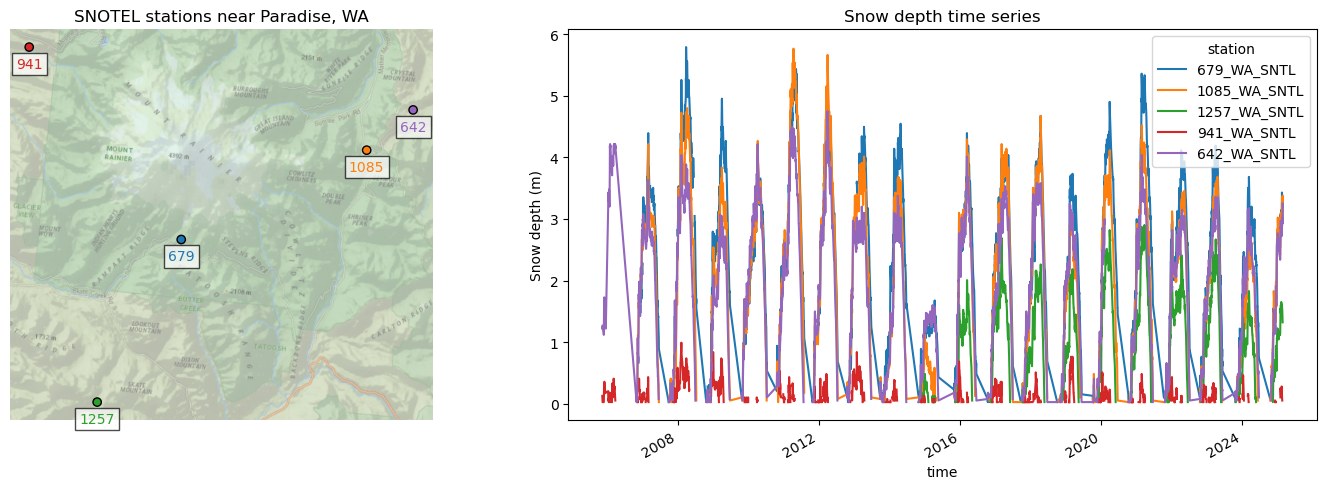

In [43]:
f, axa = plt.subplots(1,2,figsize=(15,5))

#Plot the points on a map
nearby_gdf.plot(facecolor=color_list, edgecolor='k', ax=axa[0])
#Prepare list of tuples of (x,y,label,color) to use for annotation labels
annotation_tuples = zip(nearby_gdf['geometry'].x, nearby_gdf['geometry'].y, nearby_gdf.index.str.split('_').str[0], color_list)
#Loop through the tuples and add annotations to the map
for x, y, label, c in annotation_tuples:
    axa[0].annotate(label, xy=(x,y), xytext=(0, -15), ha='center', textcoords="offset points", color=c, \
                    bbox=dict(boxstyle="square",fc='w',alpha=0.7))
    

axa[0].set_title('SNOTEL stations near Paradise, WA')
axa[0].set_aspect('equal')
axa[0].axis('off')

axa[1].set_title('Snow depth time series')
axa[1].set_ylabel('Snow depth (m)')
axa[1].set_xlabel('Date')


#Add the basemap
ctx.add_basemap(ax=axa[0], crs=nearby_gdf.crs, source=ctx.providers.Esri.NatGeoWorldMap, alpha=0.7, attribution=False)

#Plot the time series
all_stations_snwd_df[site_list].dropna(thresh=2).plot(ax=axa[1])
#all_stations_snwd_df[site_list].dropna(how='all').plot(ax=axa[1])
f.tight_layout()

### Now we'll use `.corr()` to calculate the correlation values for different combinations of stations, and seaborn's heatmap function to plot the correlation matrix

In [44]:
#The Pandas `corr` should properly handle nans
snwd_corr = all_stations_snwd_df[site_list].corr()
snwd_corr

station,679_WA_SNTL,1085_WA_SNTL,1257_WA_SNTL,941_WA_SNTL,642_WA_SNTL
station,,,,,
679_WA_SNTL,1.000000,0.946617,0.878109,0.397001,0.916370
1085_WA_SNTL,0.946617,1.000000,0.890231,0.350175,0.958519
1257_WA_SNTL,0.878109,0.890231,1.000000,0.350870,0.861648
941_WA_SNTL,0.397001,0.350175,0.350870,1.000000,0.281228
642_WA_SNTL,0.916370,0.958519,0.861648,0.281228,1.000000


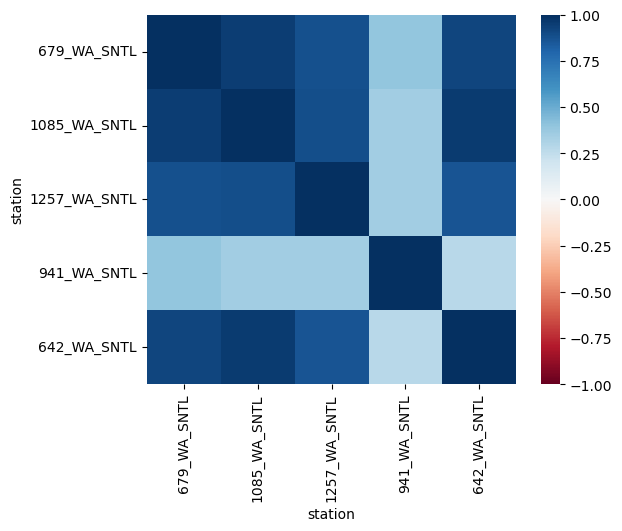

In [45]:
sns.heatmap(snwd_corr, cmap='RdBu', vmin=-1, vmax=1, square=True);

### How does the correlation coefficient change with distance?
* Select the Paradise station as your reference station

In [46]:
ref_site = '679_WA_SNTL'
equidist_crs = 'ESRI:102005'

#### *Compute the following...*
- `corr_with_ref_site_df`
    - Correlation score with your reference station
- `dist_from_ref_site_km_df`
    - Distance in km from your reference station
    - Hint: Try geopandas `.distance` function we used in lab05
    - Use the equidistant crs provided above for the distance calculation
- `elev_diff_from_ref_site_m_df`
    - Elevation difference of the sites minus the reference site

In [47]:
# STUDENT CODE HERE

In [48]:
all_stations_gdf['corr_with_ref_site'] = corr_with_ref_site_df
all_stations_gdf['dist_from_ref_site_km'] = dist_from_ref_site_km_df
all_stations_gdf['elev_diff_from_ref_site_m'] = elev_diff_from_ref_site_m_df

#### *Create a map with values representing correlation with the reference site*

In [49]:
# STUDENT CODE HERE

<img src='imgs/snotel_snwd_corr_with_ref_site.png' width="800" />

#### *Written response: How does the correlation score vary with distance from the reference site? How does this relate to Tobler's first law and the idea of spatial autocorrelation?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Create a plot of correlation scores with the reference site, with distance from site on the x-axis, and elevation difference from reference site on the y-axis*

In [50]:
# STUDENT CODE HERE

<img src='imgs/snotel_snwd_corr_vs_dist_elev.png' width="800" />

#### *Written response: If our reference station at Paradise broke, yet you needed to know the snow depth there, what factors would you consider when choosing a different site to use as a proxy?*

**STUDENT WRITTEN RESPONSE HERE**

## Part 4: Western U.S. long-term snow depth statistics (3 pts)
Now that we've analyzed temporal variability, let's look at long-term aggregations. We previously filtered out snow depths less than 1 centimeter and greater than 10 meters which improve some of these calculations.


#### *At each site, calculate...*
- *the long-term median snow depth*
- *the long-term max snow depth*
- *the 2024 water year max snow depth*
- *recent snow depth (2025-02-23)*
- *percent normal snow depth (2025-02-23)*

In [51]:
# STUDENT CODE HERE

In [52]:
# STUDENT CODE HERE

#### *Plot the variables you just calculated!*

In [53]:
# STUDENT CODE HERE

<img src='imgs/snotel_long_term_median.png' width="800" />
<img src='imgs/snotel_long_term_max.png' width="800" />
<img src='imgs/snotel_wateryear2024_max.png' width="800" />
<img src='imgs/snotel_recent_depth.png' width="800" />
<img src='imgs/snotel_recent_depth_pct_norm.png' width="800" />

#### *Written response: According to the percent of normal snow depth plot, what areas currently have a lower snow depth value than usual for this time of year? What areas have higher values than usual?*

**STUDENT WRITTEN RESPONSE HERE**

## Part 5: Spatial autocorrelation and interpolation (4 pts)
For this part, you'll want to refer back to the module 08 demo. Let's take a look at the long-term median snow depth...

In [54]:
# Let's quickly remove stations with no long term median value
stations_filtered_gdf = all_stations_gdf[['long_term_median','geometry']].dropna()

Text(0.5, 1.0, 'SNOTEL station long-term median snow depth')

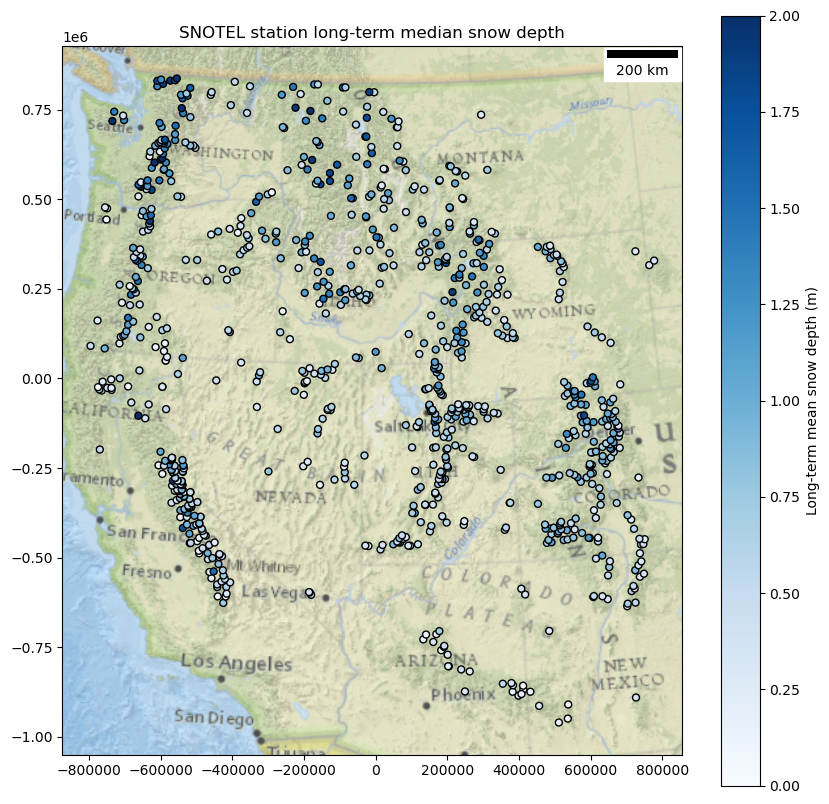

In [55]:
f,ax=plt.subplots(figsize=(10,10))
stations_filtered_gdf.plot(ax=ax,
                      column='long_term_median', 
                      cmap='Blues', 
                      legend=True, 
                      legend_kwds={'label': 'Long-term mean snow depth (m)'}, 
                      edgecolor='k',
                      markersize=25,
                      vmin=0,
                      vmax=2)
ax.add_artist(ScaleBar(1, location='upper right', units='m'))
ctx.add_basemap(ax, crs=stations_filtered_gdf.crs, source=ctx.providers.Esri.NatGeoWorldMap, alpha=0.7, attribution=False)
ax.set_title('SNOTEL station long-term median snow depth')

#### *Check for autocorrelation using Global Moran's I*
- Try two different ways of specifying your weights / connectivity!

In [56]:
y = stations_filtered_gdf['long_term_median'].values

k = 8  # Number of neighbors
w = weights.KNN.from_dataframe(stations_filtered_gdf, k=k)

# or define w based on distance
dist_threshold = 100*1000
w = weights.distance.DistanceBand.from_dataframe(stations_filtered_gdf, threshold=dist_threshold)

w.transform = 'r'  


('WARNING: ', '933_NM_SNTL', ' is an island (no neighbors)')
('WARNING: ', '1034_NM_SNTL', ' is an island (no neighbors)')
('WARNING: ', '917_MT_SNTL', ' is an island (no neighbors)')
('WARNING: ', 'NLS', ' is an island (no neighbors)')


/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 4 islands with ids: 933_NM_SNTL, 1034_NM_SNTL, 917_MT_SNTL, NLS.
  w = W(neighbors, weights, ids, **kwargs)
/home/eric/miniconda3/envs/uwgda2025/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 4 islands with ids: 933_NM_SNTL, 1034_NM_SNTL, 917_MT_SNTL, NLS.
  W.__init__(


In [57]:
# STUDENT CODE HERE

#### *Written response: What did you calculate for your Global Moran's I, and how do you interpret your results?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Now calculate Local Moran's I*

In [58]:
# STUDENT CODE HERE

#### *Make a scatterplot for Moran's I*

In [59]:
# STUDENT CODE HERE

<img src='imgs/moran_scatterplot.png' width="800" />

#### *Plot your Local Moran's I clusters on a map*

In [60]:
# STUDENT CODE HERE

In [61]:
# STUDENT CODE HERE

<img src='imgs/snotel_lisa_clusters.png' width="800" />

In [62]:
# Calculate percentage of each cluster type
total_sig = sum(stations_filtered_lisa['significant'])
for cluster_type in ['High-High', 'Low-Low', 'Low-High', 'High-Low']:
    count = sum(stations_filtered_lisa['cluster_type'] == cluster_type)
    percent = count / total_sig * 100 if total_sig > 0 else 0
    print(f"{cluster_type}: {count} points ({percent:.1f}% of significant clusters)")

# Interpret results
print("\nInterpretation of LISA clusters:")
print("- High-High clusters (hotspots): Areas with high snow depth surrounded by areas with high snow depth")
print("- Low-Low clusters (coldspots): Areas with low snow depth surrounded by areas with low snow depth")
print("- Low-High clusters: Areas with low snow depth surrounded by areas with high snow depth")
print("- High-Low clusters: Areas with high snow depth surrounded by areas with low snow depth")

High-High: 132 points (37.9% of significant clusters)
Low-Low: 139 points (39.9% of significant clusters)
Low-High: 50 points (14.4% of significant clusters)
High-Low: 27 points (7.8% of significant clusters)

Interpretation of LISA clusters:
- High-High clusters (hotspots): Areas with high snow depth surrounded by areas with high snow depth
- Low-Low clusters (coldspots): Areas with low snow depth surrounded by areas with low snow depth
- Low-High clusters: Areas with low snow depth surrounded by areas with high snow depth
- High-Low clusters: Areas with high snow depth surrounded by areas with low snow depth


#### *Written response: How do you interpret your Local Moran's I, and how does your choice of connectivity affect your results?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Now create and plot a variogram using the demo as a guide. Use n_lags of 50. Experiment with maxlags of 1km, 10km, 100km, 1,000km, 10,000km to see how the variogram and its range changes. For the purposes of this question's output and the rest of the lab, proceed with a maxlag of 100km.*

In [63]:
# STUDENT CODE HERE

Calculating empirical variogram...
Fitting variogram model...


In [64]:
# STUDENT CODE HERE

<img src='imgs/variogram.png' width="800" />

#### *Print out the variogram model parameters*

In [65]:
# STUDENT CODE HERE

Variogram Model Parameters:
Model type: spherical
Nugget: 0.0000
Sill: 0.1765
Effective range: 9.6665 km


#### *How did varying the maxlag affect your variogram and effective range? What does this sensitivity to maximum lag distance suggest? For the variogram you proceeded with (maxlag of 100km), interpret the effective range. What is this saying about snow depth physically, and does this match your intuition?*
- Hint: When thinking about the sensitivity to maximum lag distance, revisit the reading on [variogram calculation](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_variogram_calculation.html), specifically paying attention to stationarity and the brick example

**STUDENT WRITTEN RESPONSE HERE**

#### *Now try interpolating the sparse snow depth points and plot a median snow depth raster using two deterministic interpolation methods, nearest interpolation and radial basis functions with a linear kernel*
- For context, plot the states underneath and also the median snow depth point values (use the same colorbar as the raster)

In [66]:
x = coords[:,0]
y = coords[:,1]
z = values

bounds = stations_filtered_gdf.total_bounds
dx,dy = (3000,3000)

mpl_extent = (bounds[0],bounds[2],bounds[1],bounds[3])


xi = np.arange(np.floor(bounds[0]), np.ceil(bounds[2]),dx)
yi = np.arange(np.ceil(bounds[3]),np.floor(bounds[1]),-dy)
xx, yy = np.meshgrid(xi, yi)

In [67]:
interp_func_rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
interp_rbf = interp_func_rbf(xx, yy)
interp_nearest = scipy.interpolate.griddata((x,y), z, (xx, yy), method='nearest')

In [68]:
# STUDENT CODE HERE

<img src='imgs/snotel_snwd_interpolation.png' width="800" />

#### *Finally, use the variogram you created to do Kriging interpolation and plot a median snow depth raster*

In [69]:
ok = skg.OrdinaryKriging(V, min_points=1, max_points=15, mode='exact')
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

In [70]:
# STUDENT CODE HERE

<img src='imgs/snotel_snwd_kriging.png' width="800" />

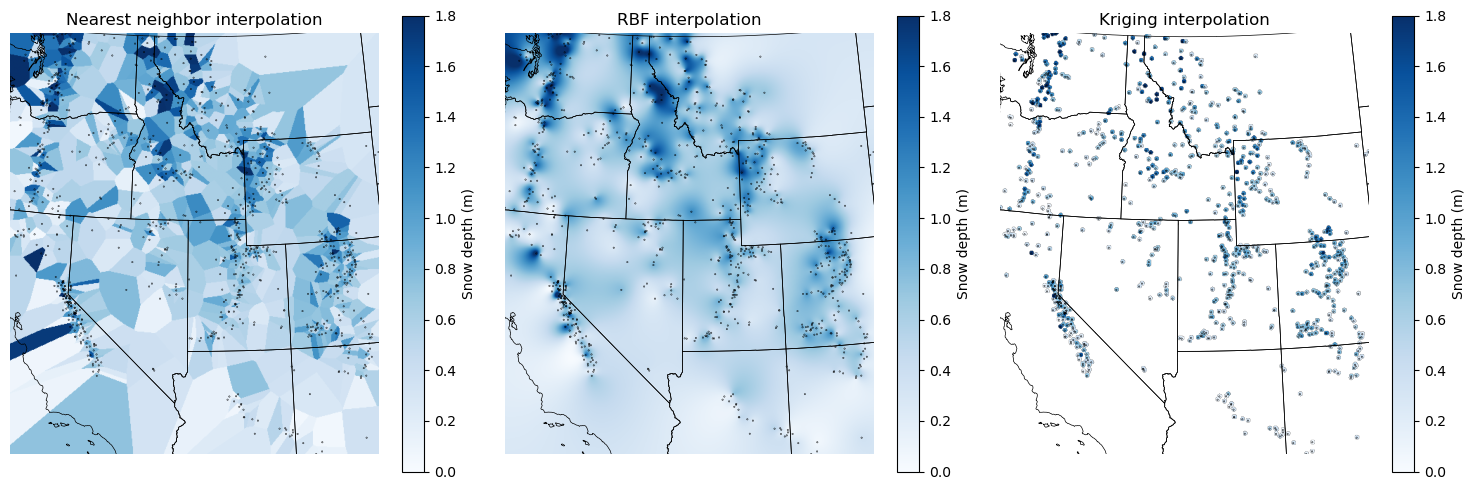

In [71]:
f,axs=plt.subplots(1,3,figsize=(15,5))

axs[0].imshow(interp_nearest, extent=mpl_extent, cmap='Blues',vmin=0,vmax=1.8)
axs[0].set_title('Nearest neighbor interpolation')

axs[1].imshow(interp_rbf, extent=mpl_extent, cmap='Blues',vmin=0,vmax=1.8)
axs[1].set_title('RBF interpolation')

axs[2].imshow(field, extent=mpl_extent, cmap='Blues', vmin=0, vmax=1.8)
axs[2].set_title('Kriging interpolation')

for ax in axs:
    ax.set_xlim(bounds[0],bounds[2])
    ax.set_ylim(bounds[1],bounds[3])
    states_gdf.boundary.plot(ax=ax, color='k', linewidth=0.5)
    stations_filtered_gdf.plot(ax=ax, column='long_term_median', cmap='Blues', legend=True, legend_kwds={'label': 'Snow depth (m)'}, markersize=0.1, vmin=0, vmax=1.8, edgecolor='k')
    ax.set_aspect('equal')
    ax.axis('off')

f.tight_layout()


#### *Written response: Interpret your interpolations! For each interpolation, describe a use case where you'd prefer this interpolation over the other two. For the Kriging interpolation, why are only small areas around the points interpolated?*

**STUDENT WRITTEN RESPONSE HERE**

## Submission
- Save the completed notebook (make sure to fully run the notebook and check all cell output is visible)
- Use the `git add; git commit -m 'message'; git push` workflow to push your work to the remote repository 
    - ideally you've been using add / commit / push as you make progress on this notebook
- Check the remote repository to check all of the files you want to submit have been pushed
- **Scroll through your jupyter notebook on your remote repository and make sure all output and plots are visible**
- When you have completed your last push, submit the url pointing to your Github repository to the corresponding Canvas assignment